In [1]:
from keras.models import clone_model
from kerassurgeon.operations import delete_layer, insert_layer
from models.VLAE import VLAE

vlae_fm1 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=1,
                z_dims=[2,2,2])
vlae_fm1.load_weights("/Users/leo/Downloads/Models/mnist_vlae_factor_1.h5")

vlae_fm2 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=2,
                z_dims=[2,2,2])
vlae_fm2.load_weights("/Users/leo/Downloads/Models/mnist_vlae_factor_2.h5")

vlae_fm3 = VLAE(input_dim=(28,28,1),
                inf0_kernels_strides_featuremaps=[(5, 2, 64)],
                inf1_kernels_strides_featuremaps=[(3, 2, 64)],
                ladder0_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder1_kernels_strides_featuremaps=[(5, 2, 64)],
                ladder2_kernels_strides_featuremaps=[(3, 1, 64), (3, 1, 64)],
                gen2_num_units=[1024, 1024],
                gen1_num_units=[1024, 1024],
                gen0_kernels_strides_featuremaps=[(5, 2, 64), (3, 2, 64), (5, 1, 1)],
                use_dropout=False, use_batch_norm=False, log_dir="ok", kernel_visualization_layer=1, num_samples=5,
                feature_map_layers=[1], inner_activation="ReLU", decay_rate=.0, feature_map_reduction_factor=3,
                z_dims=[2,2,2])
vlae_fm3.load_weights("/Users/leo/Downloads/Models/mnist_vlae_factor_3.h5")

Using TensorFlow backend.












In [3]:
import keras
import numpy as np
from typing import List
from keras import backend as K
class FewActiveLayer(keras.layers.Layer):
    def __init__(self, active_idxs: List[int], mean_activities: np.ndarray, **kwargs):
        super(FewActiveLayer, self).__init__(**kwargs)
        self.mean_activities = mean_activities
        self.active_idxs = active_idxs
        self.inactive_idxs = np.setdiff1d(np.arange(0, mean_activities.shape[-1]), self.active_idxs)

    def get_config(self):
        return {'n_dft':32,'class_name':'Conv2D'}


    def call(self, inputs):
        output_list = []
        for feature_map_idx in range(self.mean_activities.shape[-1]):
            if feature_map_idx in self.active_idxs:
                output_list.append(inputs[:,:,:,feature_map_idx])
            else:
                output_list.append(K.variable(np.stack([mean_activities[:,:,feature_map_idx]]*32)))
        res = K.stack(output_list, axis=-1)
        return res

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inference_0_conv2d_0 (Conv2D)   (None, 14, 14, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
inference_0_relu_0 (ReLU)       (None, 14, 14, 64)   0           inference_0_conv2d_0[0][0]       
__________________________________________________________________________________________________
inference_1_conv2d_0 (Conv2D)   (None, 7, 7, 64)     36928       inference_0_relu_0[0][0]         
____________________________________________________________________________________________

inference_0_conv2d_0 - top activies: [25, 15, 7, 21, 11, 8, 22, 9]
inference_1_conv2d_0 - top activies: [17, 24, 22, 10, 12, 14, 7, 19]
ladder_2_conv2d_0 - top activies: [12, 29, 24, 6, 18, 0, 21, 7]
ladder_0_conv2d_0 - top activies: [1, 6, 11, 12, 26, 5, 20, 17]
ladder_1_conv2d_0 - top activies: [29, 14, 16, 6, 30, 19, 22, 18]
ladder_2_conv2d_1 - top activies: [4, 22, 7, 18, 25, 27, 1, 14]
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inference_0_conv2d_0 (Conv2D)   (None, 14, 14, 22)   572         input_3[0][0]                    
______________________________________________________________________________________________

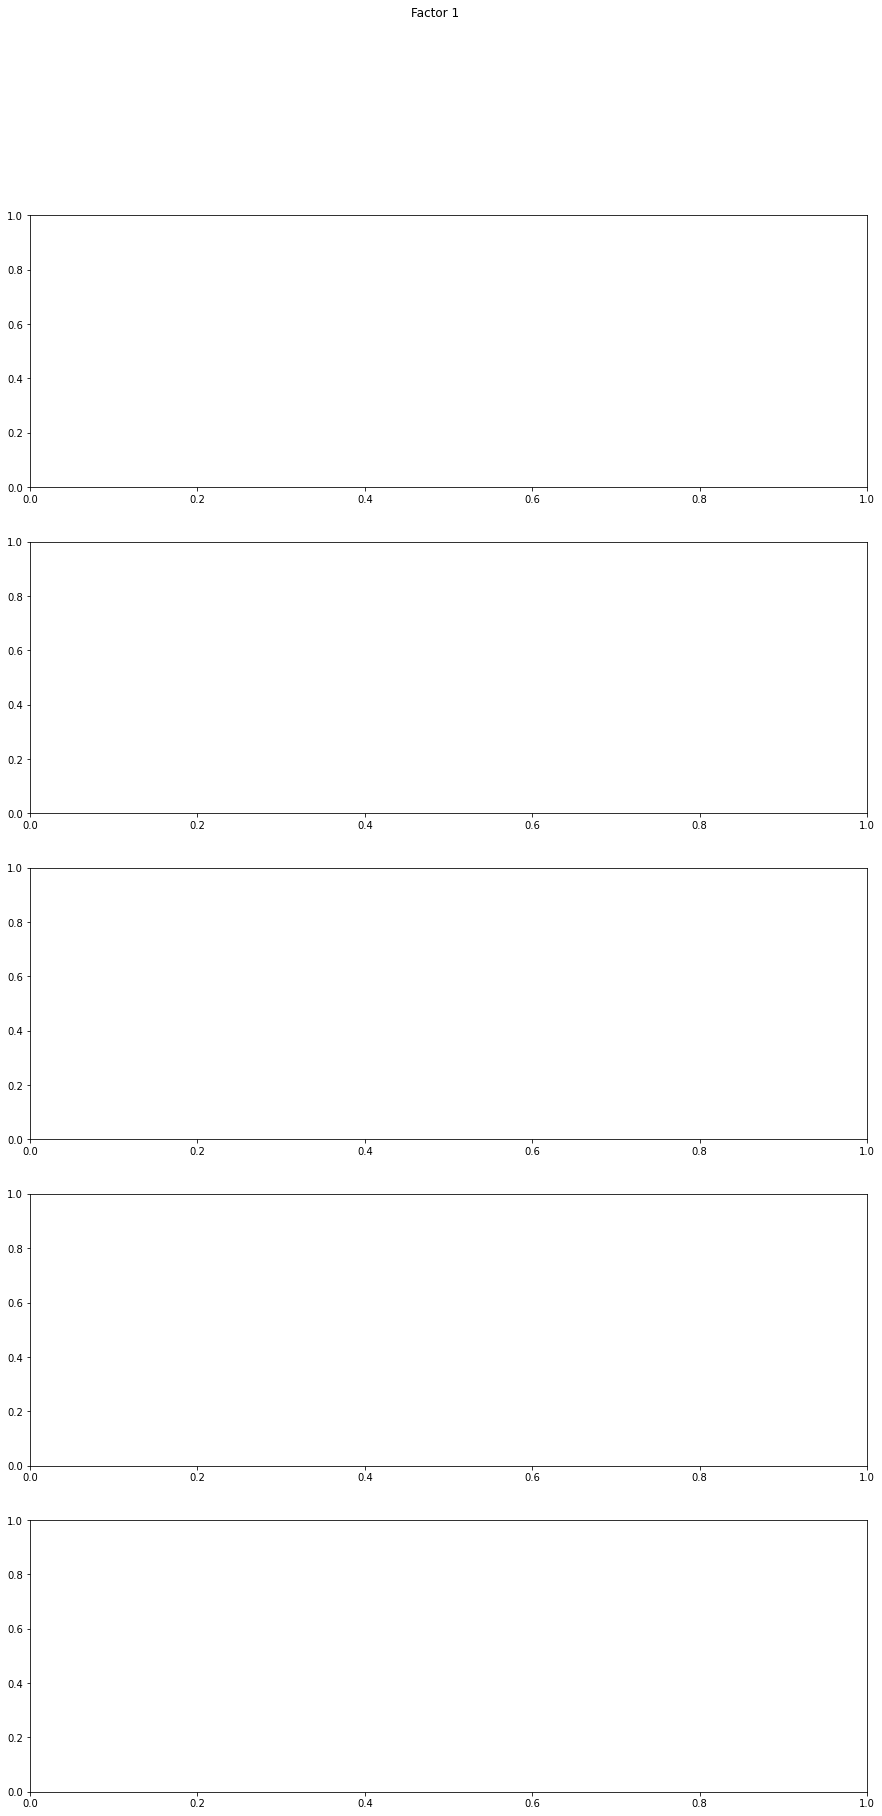

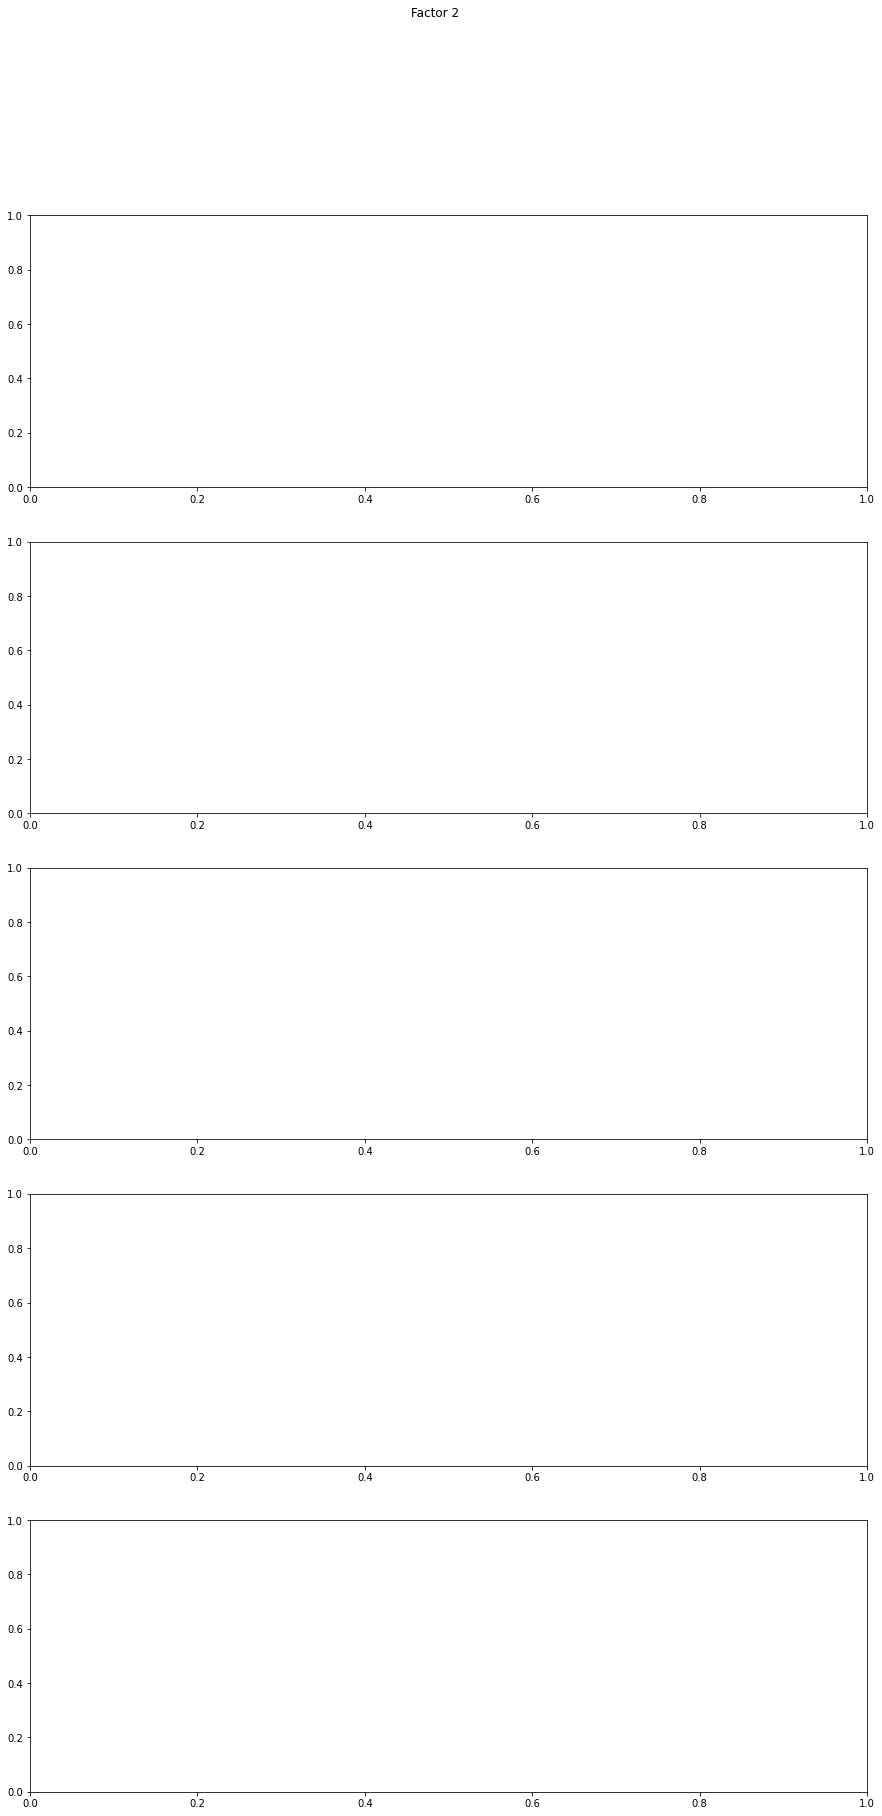

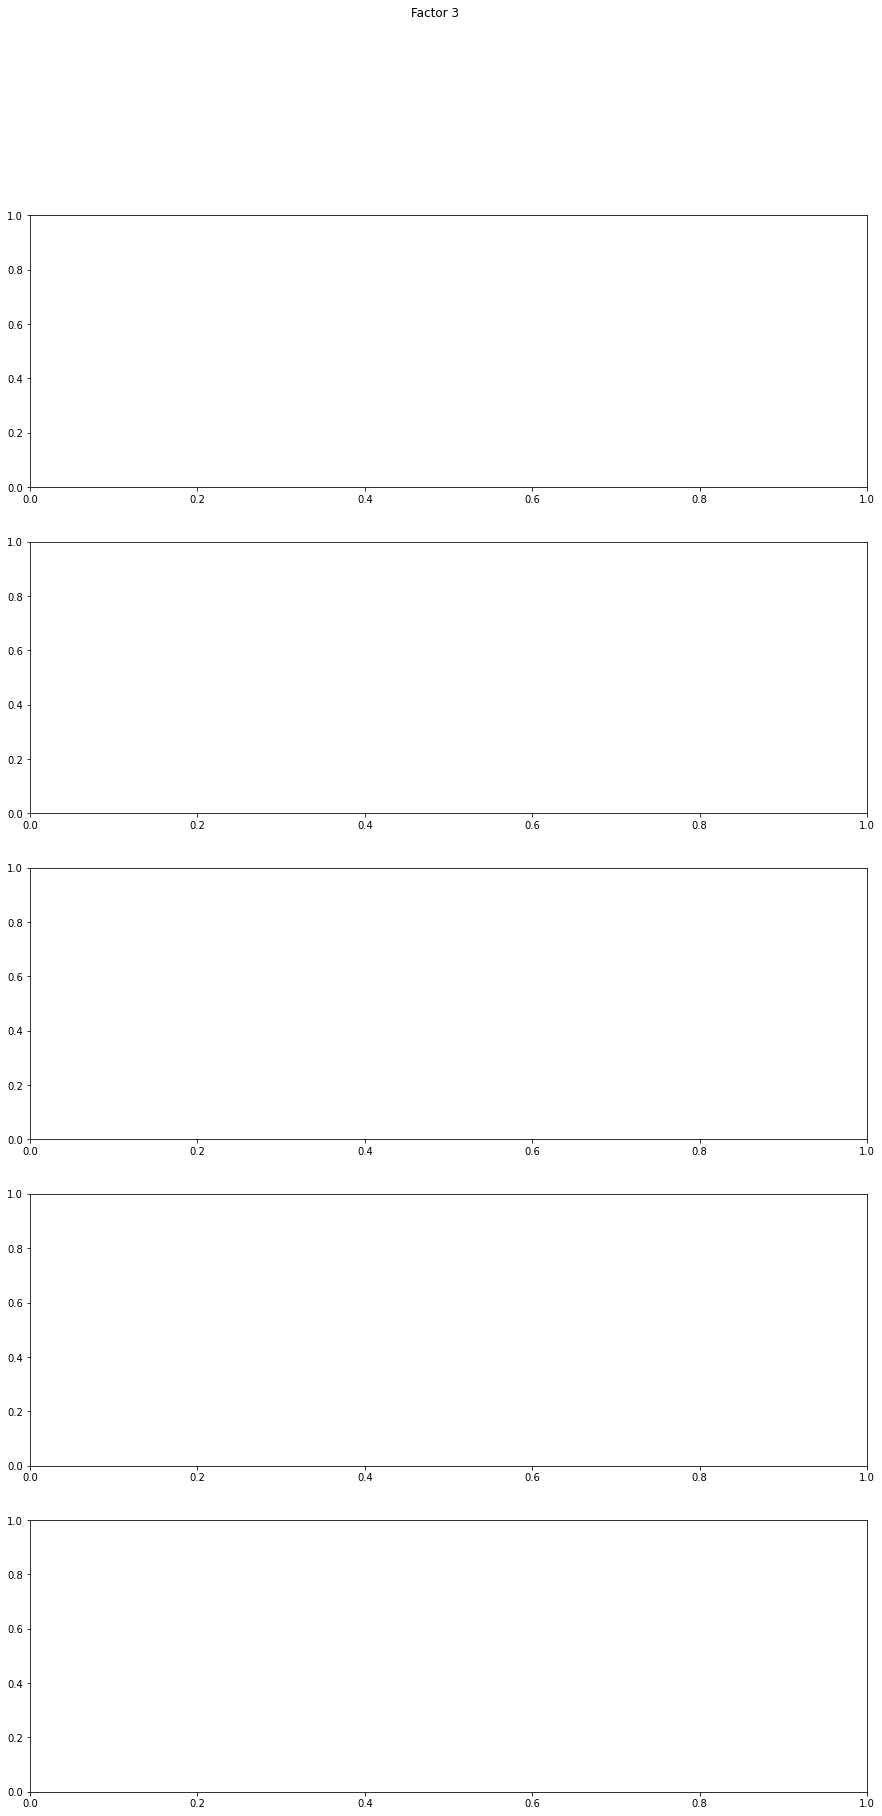

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import Model
from keras.layers import Input, Conv2D, Lambda, Dense, ReLU
from utils.vae_utils import sampling

(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

def top_argmax(arr, n):
    arr = np.copy(arr)
    arr = arr.flatten()
    maxs = []
    for i in range(min(n, len(arr))):
        max = np.argmax(arr)
        maxs.append(max)
        arr[max] = -np.inf
    return maxs

new_encoders = {}

for name, model in [("Factor 1",vlae_fm1), ("Factor 2",vlae_fm2), ("Factor 3",vlae_fm3)]:
    encoder = clone_model(model.encoder)
    encoder.set_weights(model.encoder.get_weights())
    encoder.summary()

    conv_layers = [l for l in encoder.layers if isinstance(l, Conv2D)]
    print(name)
    print('==============================')
    [print(l.name) for l in conv_layers]
    print('==============================')
    multi_output_model = Model(encoder.inputs, [l.output for l in conv_layers])
    
    preds = multi_output_model.predict(np.expand_dims(x_val / 255.0, -1))
    
    fig, axs = plt.subplots(ncols = 1, nrows = len(conv_layers)-1, figsize = (15,5*len(conv_layers)-1))
    fig.suptitle(name)

    x = l0 = i0 = None
    num_conv_layers = 0
    for i, layer in enumerate(encoder.layers):
        if i == 0:
            l0 = i0 = x = inp = Input(shape=layer.batch_input_shape[1:])
        else:
            if isinstance(layer, Lambda):
                if 'z_1' in layer.name:
                    y = Lambda(sampling, name=layer.name)([mu_1, log_var_1])
                elif 'z_2' in layer.name:
                    y = Lambda(sampling, name=layer.name)([mu_2, log_var_2])
                else:
                    y = Lambda(sampling, name=layer.name)([mu_3, log_var_3])
            else:
                y = layer.__class__(**layer.get_config())
            #y.set_weights(layer.get_weights())
            if 'ladder_0' in layer.name or 'mu_1' in layer.name or 'log_var_1' in layer.name or 'z_1' in layer.name:
                if not 'z_1' in layer.name and not 'mu_1' in layer.name and not 'log_var_1' in layer.name:
                    x = l0 = y(l0)
                    if isinstance(layer, Conv2D):
                        activies = np.mean(preds[num_conv_layers], axis=(1,2))
                        num_fms = activies.shape[-1]
                        top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                        print(f'{layer.name} - top activies: {top_activity_idxs}')
                        mean_activities = np.mean(preds[num_conv_layers], axis=0)
                        x = l0 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                        num_conv_layers+=1
                elif 'mu_1' in layer.name:
                    mu_1 = y(l0)
                elif 'log_var_1' in layer.name:
                    log_var_1 = y(l0)
                else:
                    x = l0 = y
            else:
                if 'inference_0' in layer.name:
                    x = l1 = i1 = i0 = y(i0)
                    if isinstance(layer, Conv2D):
                        activies = np.mean(preds[num_conv_layers], axis=(1,2))
                        num_fms = activies.shape[-1]
                        top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                        print(f'{layer.name} - top activies: {top_activity_idxs}')
                        mean_activities = np.mean(preds[num_conv_layers], axis=0)
                        x = l1 = i1 = i0 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                        num_conv_layers+=1
                elif 'ladder_1' in layer.name or 'mu_2' in layer.name or 'log_var_2' in layer.name or 'z_2' in layer.name:
                    if not 'z_2' in layer.name and not 'mu_2' in layer.name and not 'log_var_2' in layer.name:
                        x = l1 = y(l1)
                        if isinstance(layer, Conv2D):
                            activies = np.mean(preds[num_conv_layers], axis=(1,2))
                            num_fms = activies.shape[-1]
                            top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                            print(f'{layer.name} - top activies: {top_activity_idxs}')
                            mean_activities = np.mean(preds[num_conv_layers], axis=0)
                            x = l1 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                            num_conv_layers+=1
                    elif 'mu_2' in layer.name:
                        mu_2 = y(l1)
                    elif 'log_var_2' in layer.name:
                        log_var_2 = y(l1)
                    else:
                        x = l1 = y

                else:
                    if not 'z_3' in layer.name and not 'mu_3' in layer.name and not 'log_var_3' in layer.name:
                        x = i1 = y(i1)
                        if isinstance(layer, Conv2D):
                            activies = np.mean(preds[num_conv_layers], axis=(1,2))
                            num_fms = activies.shape[-1]
                            top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
                            print(f'{layer.name} - top activies: {top_activity_idxs}')
                            mean_activities = np.mean(preds[num_conv_layers], axis=0)
                            x = i1 = FewActiveLayer(top_activity_idxs, mean_activities, input_shape=layer.output_shape, name = f"{'_'.join(layer.name.split('_')[:2])}_few_active_{layer.name.split('_')[-1]}")(x)
                            num_conv_layers+=1
                    elif 'mu_3' in layer.name:
                        mu_3 = y(i1)
                    elif 'log_var_3' in layer.name:
                        log_var_3 = y(i1)
                    else:
                        x = i1 = y



    new_encoder = Model(inp, [l0, l1, i1])
    new_encoders[f"{name} - Inactive Maps"] = new_encoder
    print('========')

    for layer in new_encoder.layers:
        if isinstance(layer, (Conv2D, Dense, ReLU)):
            layer.set_weights(encoder.get_layer(name = layer.name).get_weights())

In [ ]:
len(x_val)

In [ ]:
preds = vlae_fm3.decoder.predict(new_encoder.predict(np.expand_dims(x_train[:128]/255.0,-1), batch_size=32))


Factor 1 - Inactive Maps
inference_0_few_active_0 - top activies: [6, 15, 57, 1, 16, 23, 32, 31, 22, 18, 54, 62, 40, 9, 4, 19]
inference_1_few_active_0 - top activies: [36, 52, 15, 18, 12, 54, 3, 8, 42, 14, 39, 58, 16, 24, 49, 22]
ladder_2_few_active_0 - top activies: [26, 39, 1, 45, 56, 43, 23, 18, 51, 44, 42, 20, 61, 50, 28, 54]
ladder_0_few_active_0 - top activies: [49, 54, 36, 3, 5, 6, 18, 10, 55, 34, 56, 44, 15, 26, 48, 39]
ladder_1_few_active_0 - top activies: [45, 0, 43, 3, 17, 47, 5, 11, 13, 59, 19, 51, 33, 54, 22, 34]
ladder_2_few_active_1 - top activies: [6, 48, 36, 21, 9, 60, 63, 61, 7, 28, 46, 47, 23, 24, 1, 30]


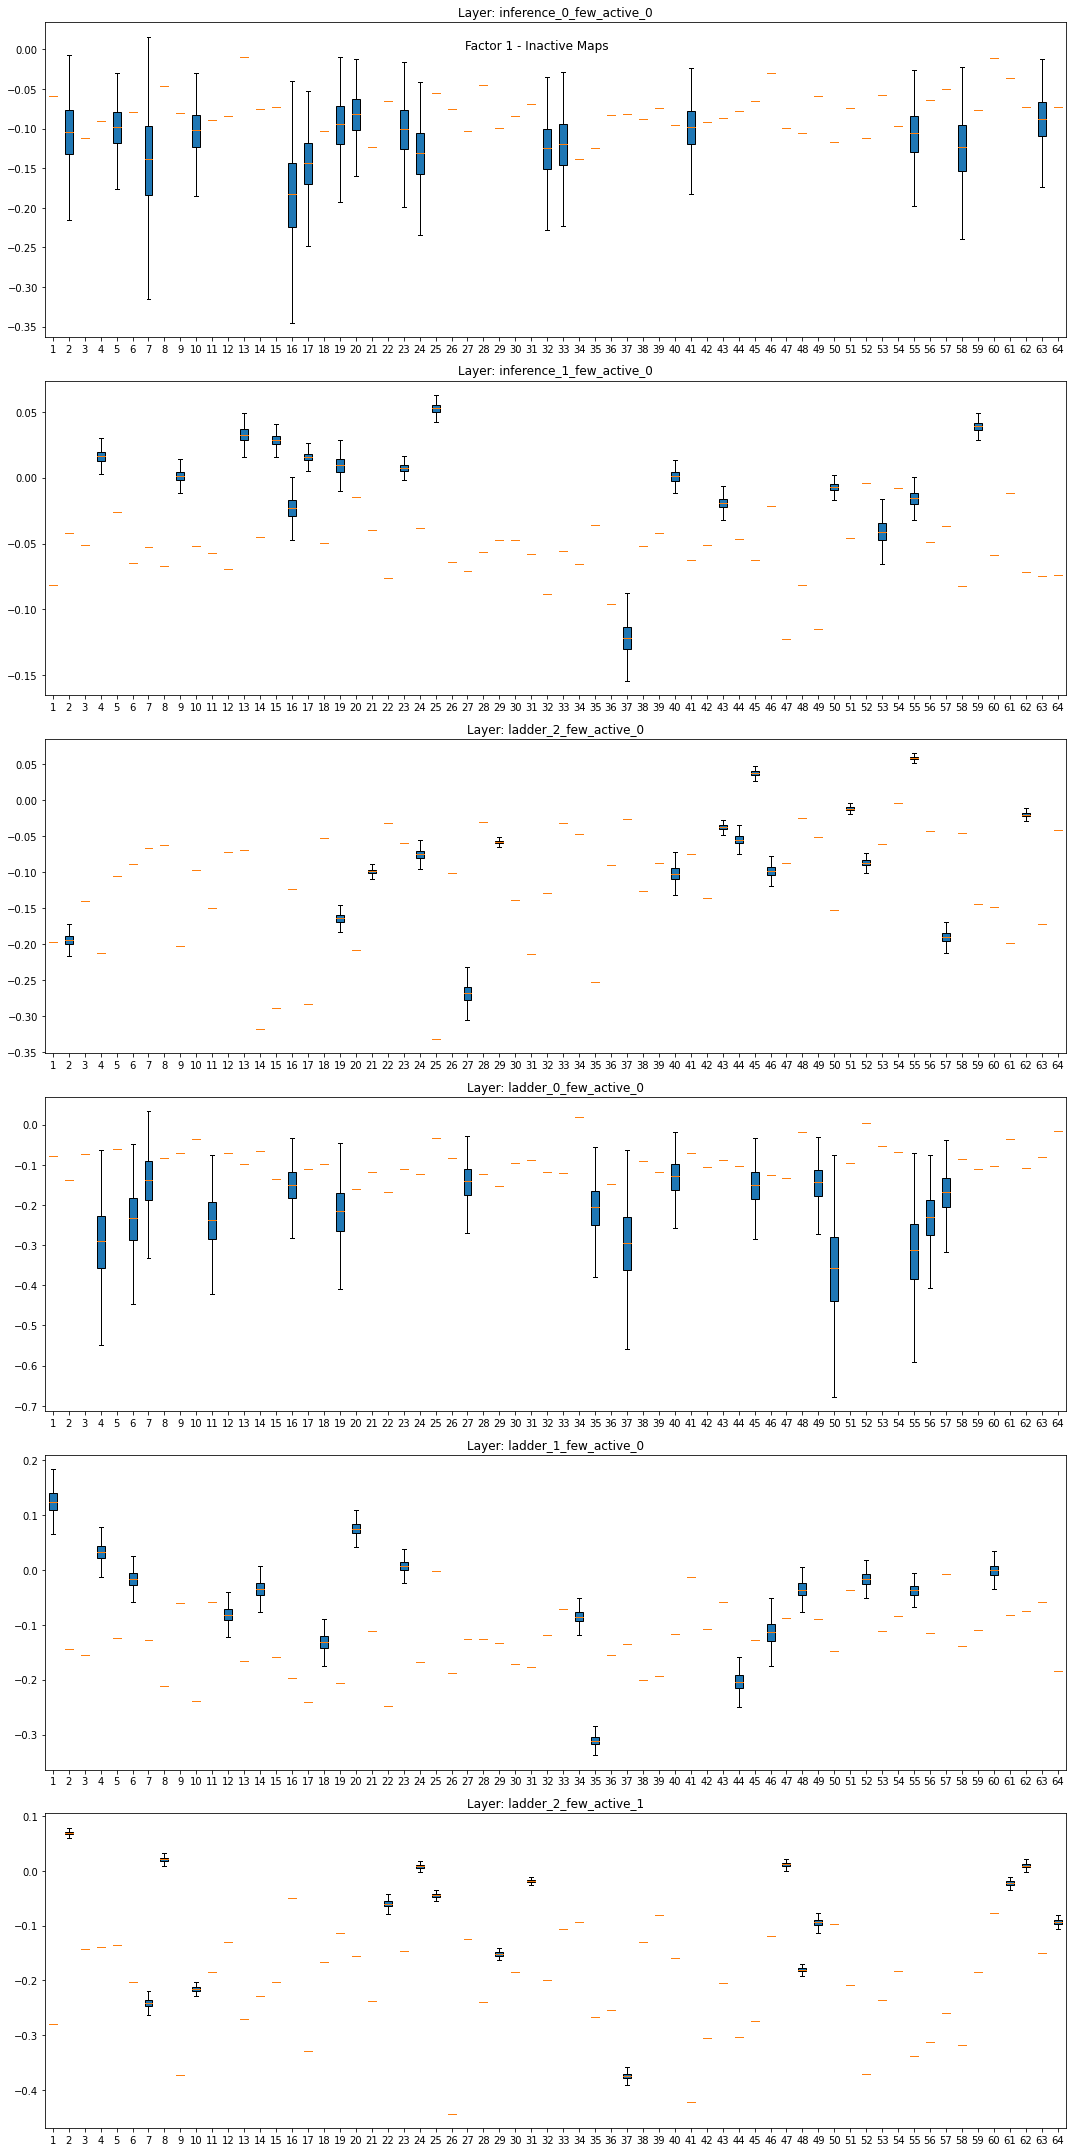

Factor 2 - Inactive Maps
inference_0_few_active_0 - top activies: [25, 15, 7, 21, 11, 8, 22, 9]
inference_1_few_active_0 - top activies: [22, 7, 24, 12, 10, 14, 17, 19]
ladder_2_few_active_0 - top activies: [7, 12, 24, 18, 21, 6, 29, 0]
ladder_0_few_active_0 - top activies: [1, 6, 11, 12, 26, 5, 20, 17]
ladder_1_few_active_0 - top activies: [19, 16, 30, 14, 6, 29, 22, 18]
ladder_2_few_active_1 - top activies: [4, 22, 18, 14, 1, 27, 7, 25]


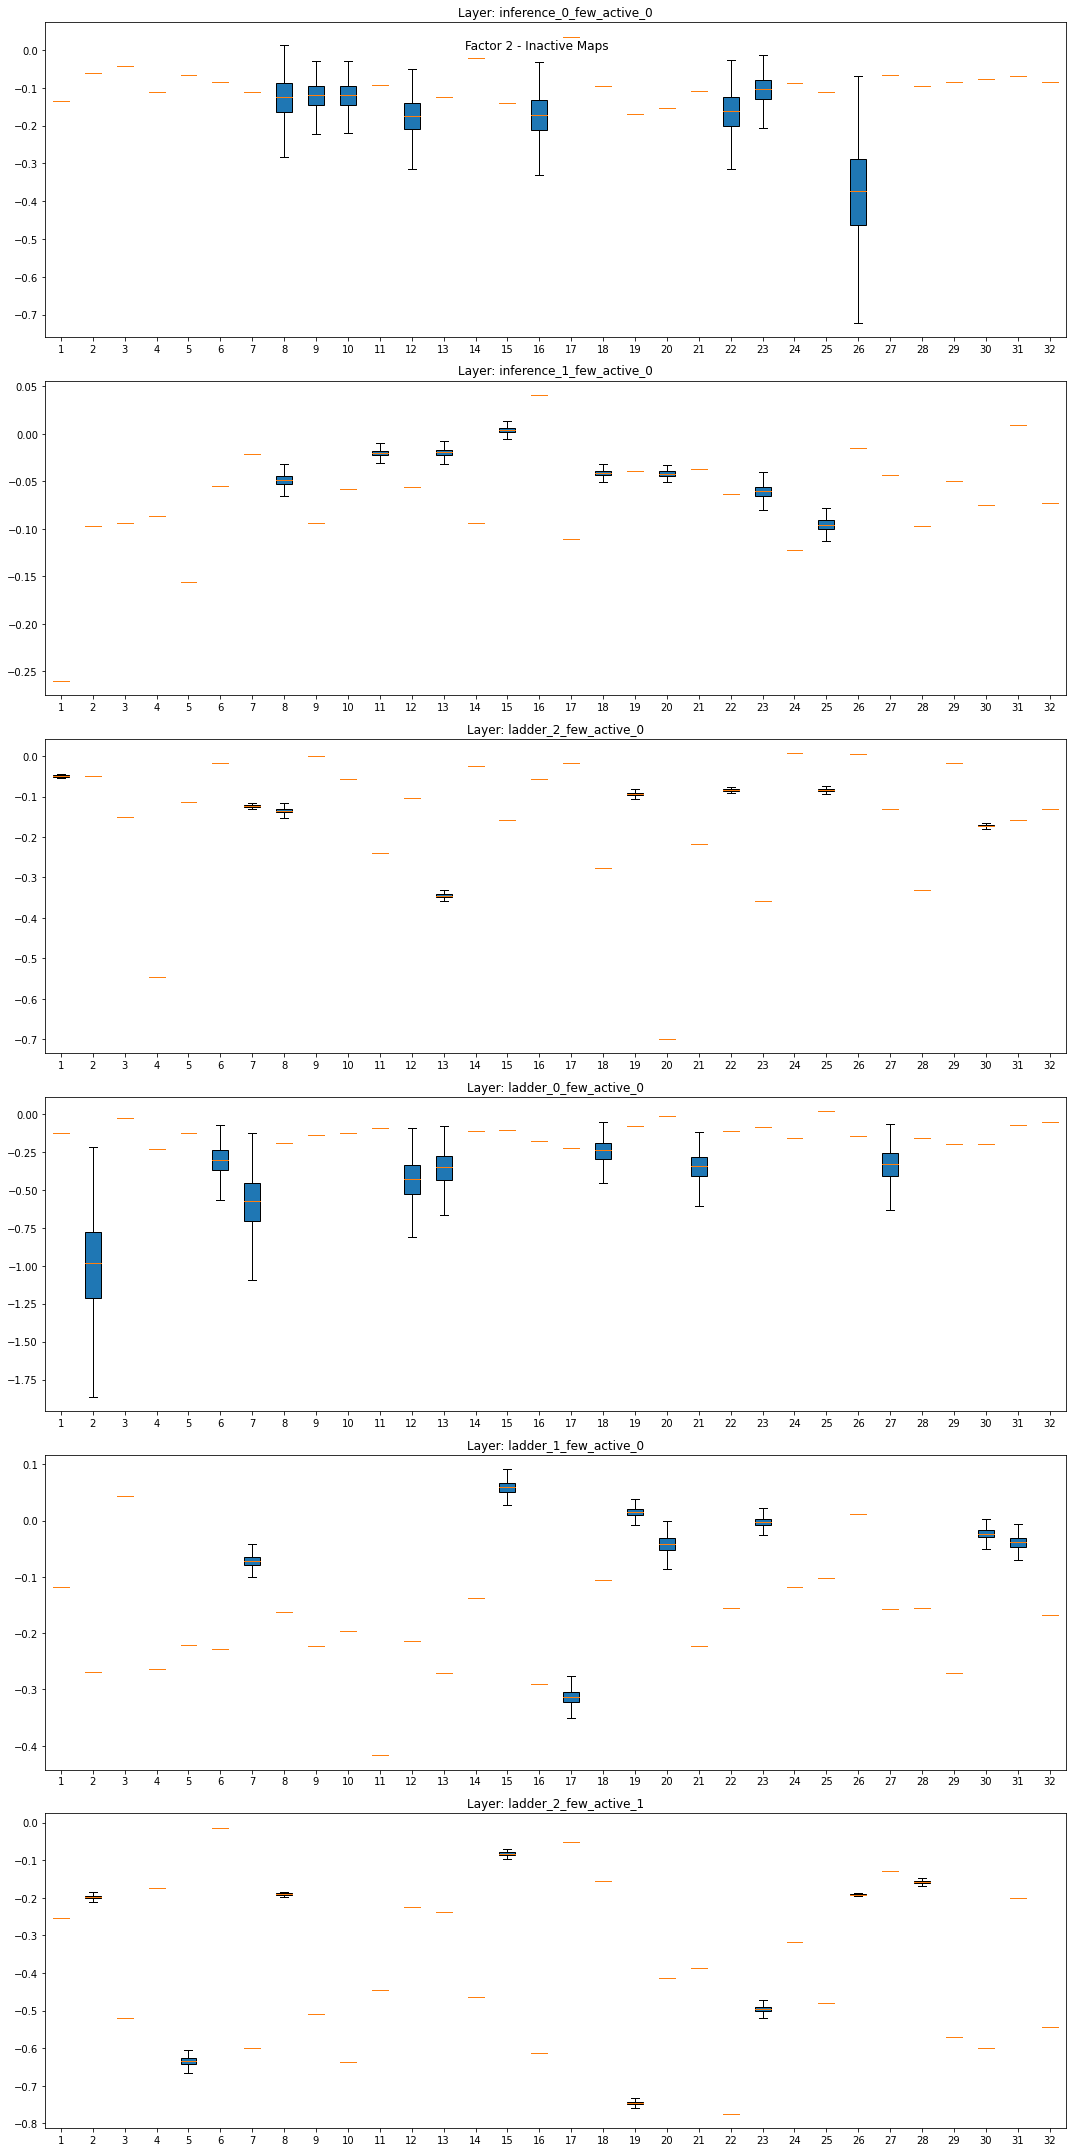

Factor 3 - Inactive Maps
inference_0_few_active_0 - top activies: [4, 16, 17, 18, 15]
inference_1_few_active_0 - top activies: [0, 1, 21, 2, 16]
ladder_2_few_active_0 - top activies: [7, 1, 16, 19, 4]
ladder_0_few_active_0 - top activies: [16, 0, 1, 13, 21]
ladder_1_few_active_0 - top activies: [17, 18, 12, 11, 15]
ladder_2_few_active_1 - top activies: [19, 7, 0, 4, 14]


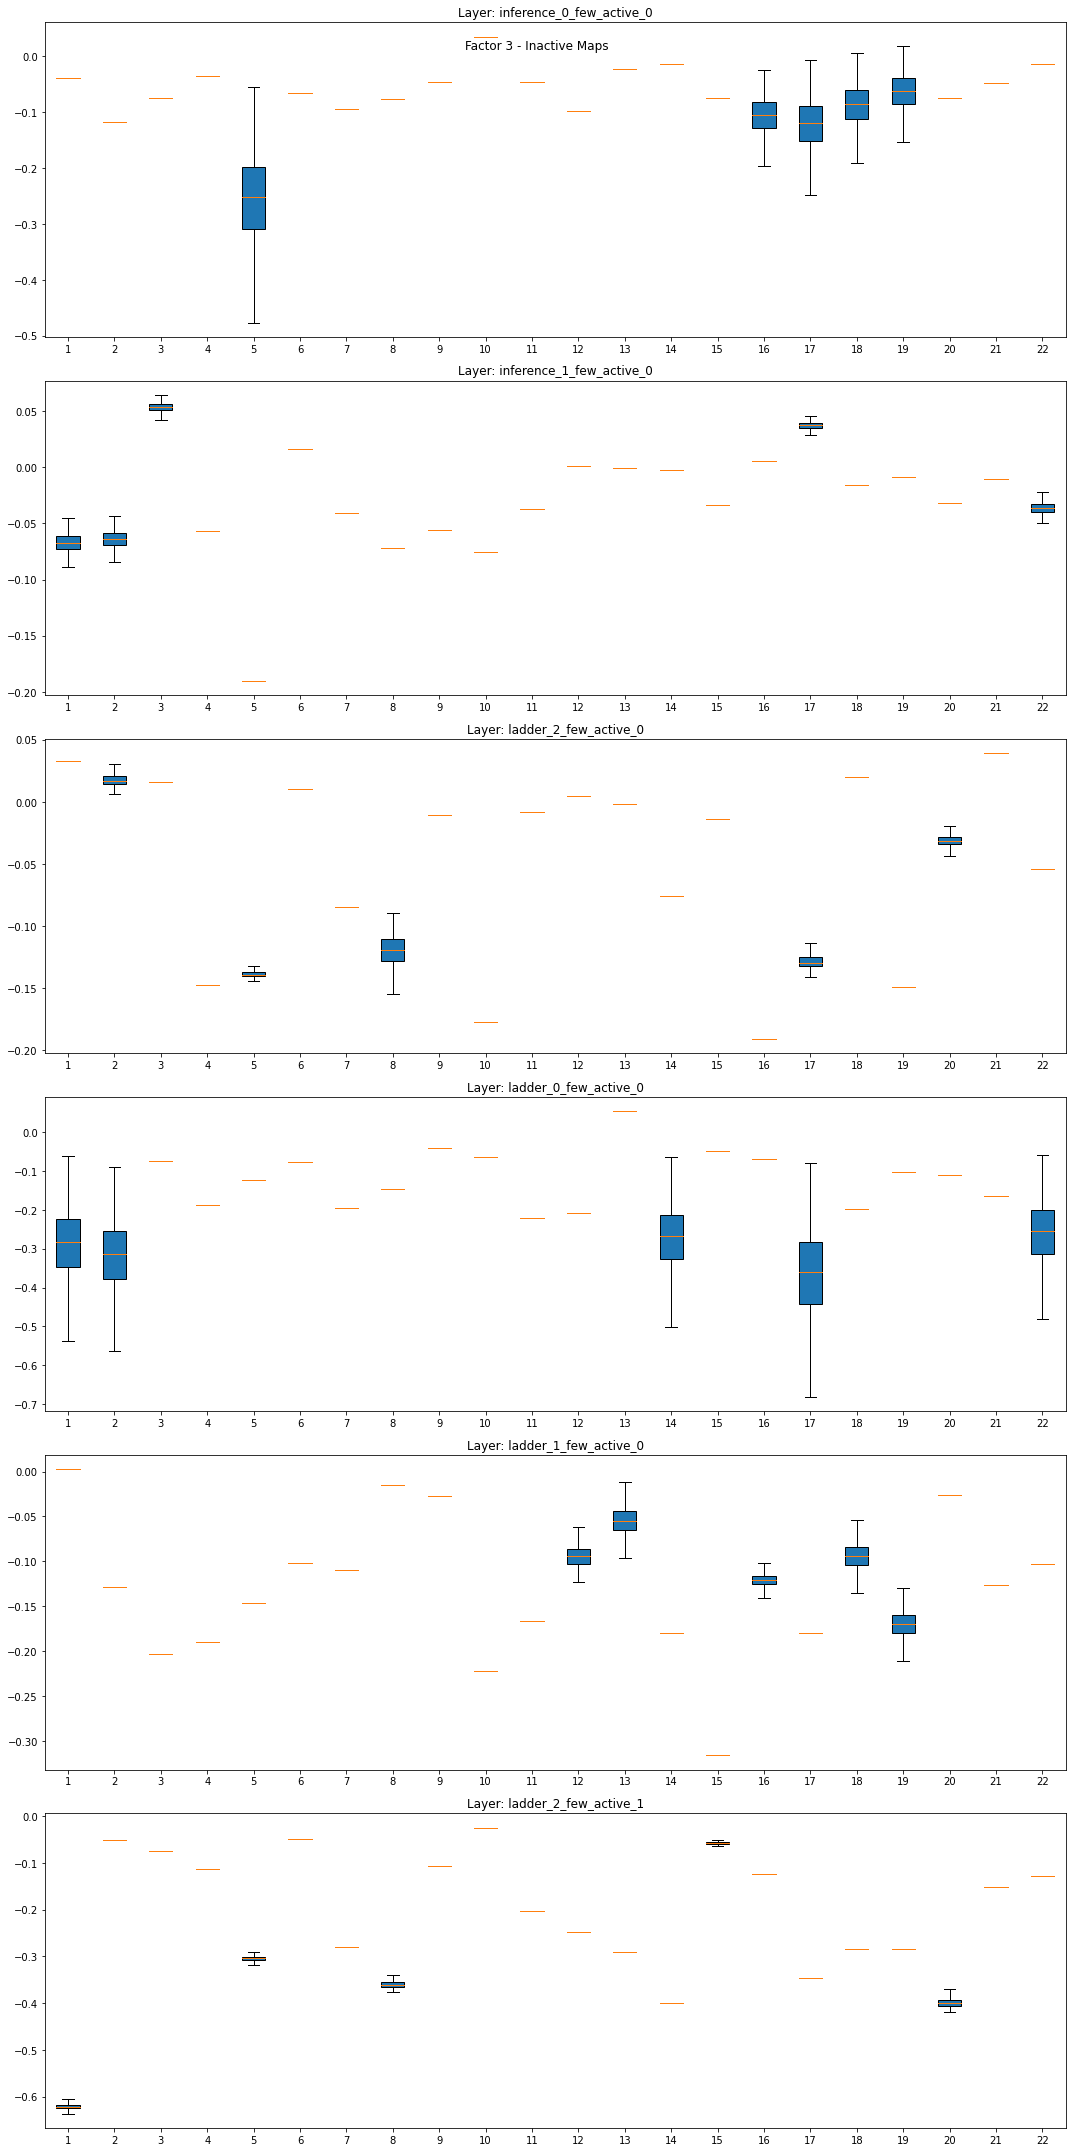

Factor 1
inference_0_conv2d_0 - top activies: [6, 15, 57, 1, 16, 23, 32, 31, 22, 18, 54, 62, 40, 9, 4, 19]
inference_1_conv2d_0 - top activies: [52, 12, 24, 16, 49, 39, 3, 22, 58, 15, 18, 14, 54, 36, 8, 42]
ladder_2_conv2d_0 - top activies: [56, 18, 51, 43, 20, 54, 42, 50, 26, 1, 61, 28, 23, 39, 44, 45]
ladder_0_conv2d_0 - top activies: [49, 54, 36, 3, 5, 6, 18, 10, 55, 34, 56, 44, 15, 26, 48, 39]
ladder_1_conv2d_0 - top activies: [17, 43, 47, 19, 22, 34, 45, 0, 11, 59, 51, 33, 5, 54, 13, 3]
ladder_2_conv2d_1 - top activies: [28, 24, 60, 36, 7, 47, 1, 63, 6, 46, 23, 9, 48, 61, 21, 30]


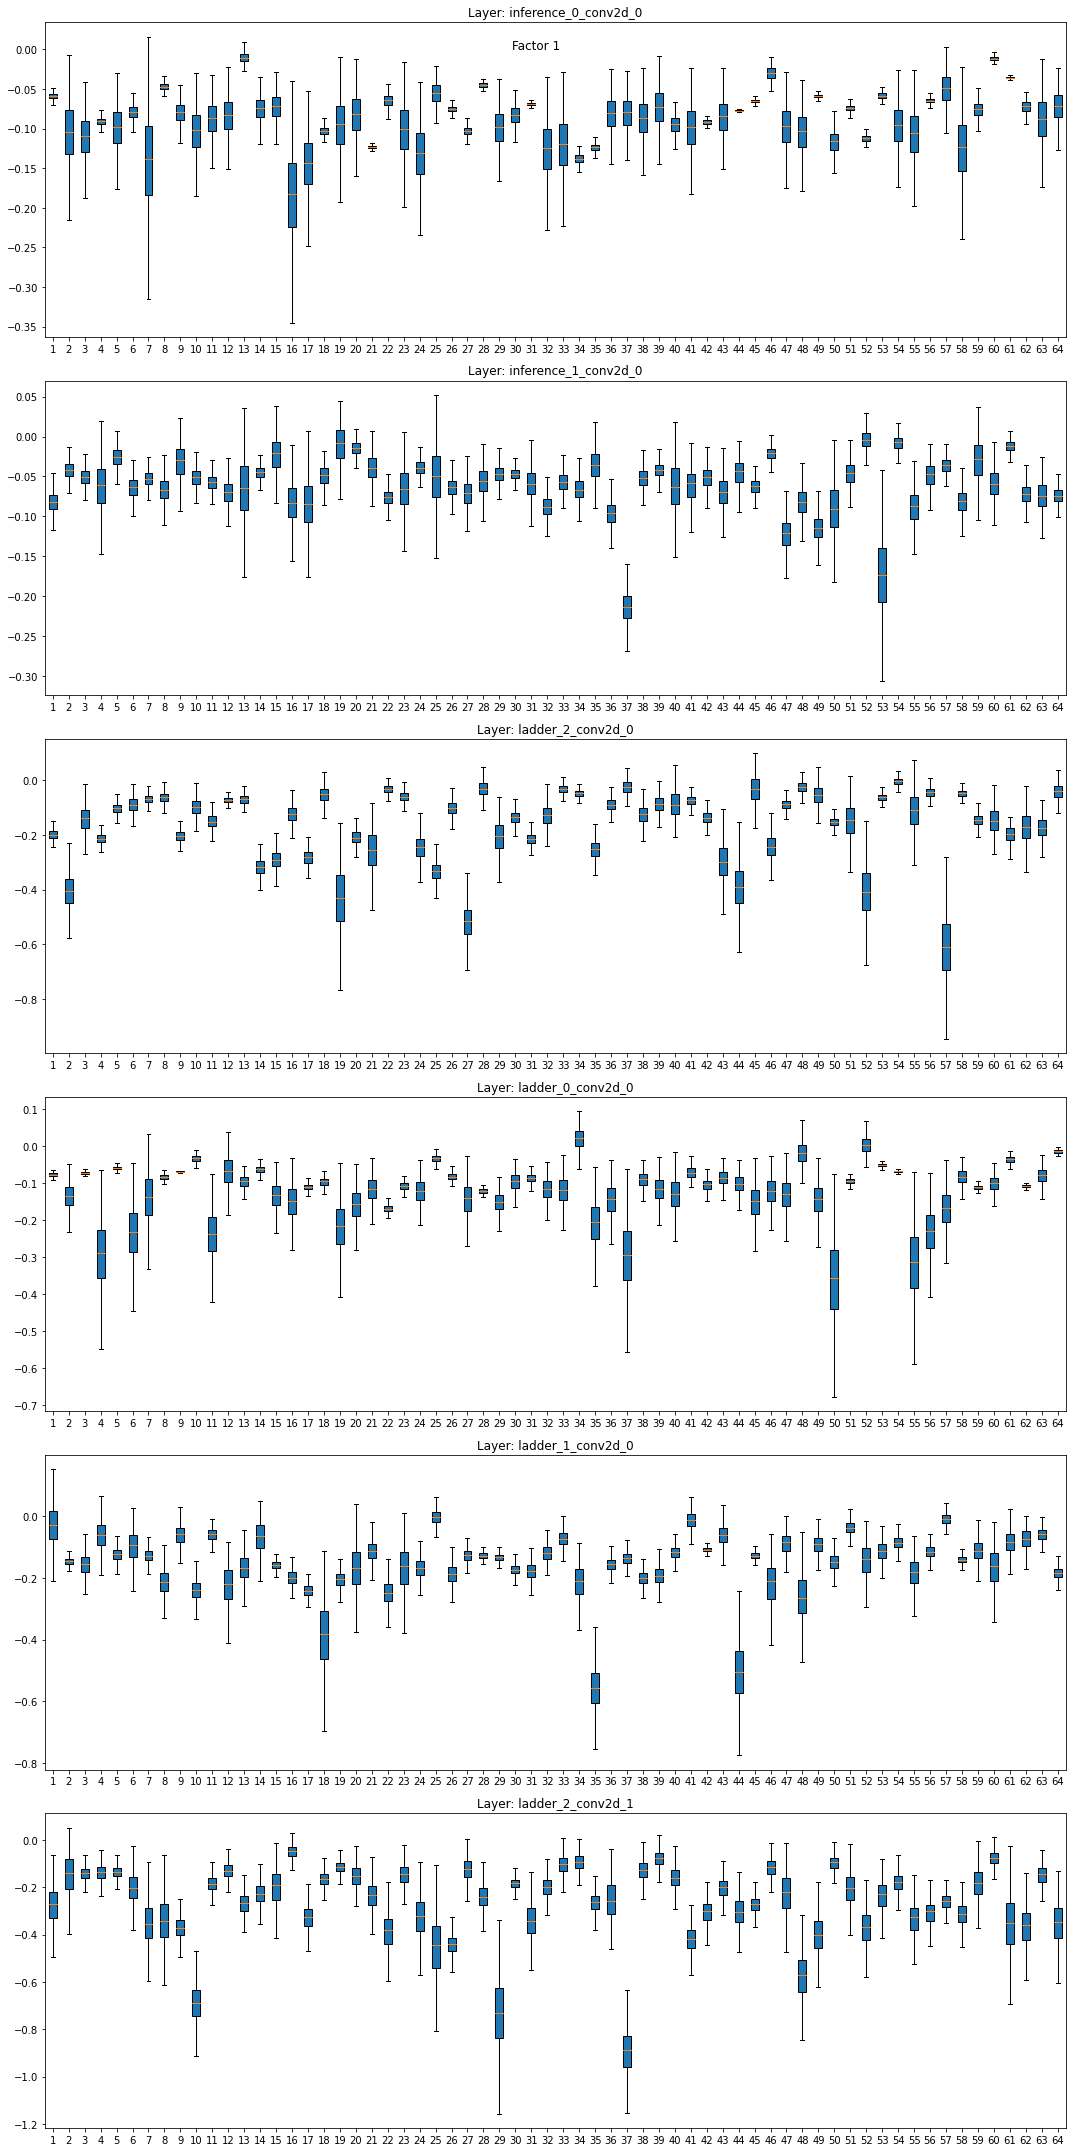

Factor 2
inference_0_conv2d_0 - top activies: [25, 15, 7, 21, 11, 8, 22, 9]
inference_1_conv2d_0 - top activies: [17, 24, 22, 10, 12, 14, 7, 19]
ladder_2_conv2d_0 - top activies: [12, 29, 24, 6, 18, 0, 21, 7]
ladder_0_conv2d_0 - top activies: [1, 6, 11, 12, 26, 5, 20, 17]
ladder_1_conv2d_0 - top activies: [29, 14, 16, 6, 30, 19, 22, 18]
ladder_2_conv2d_1 - top activies: [4, 22, 7, 18, 25, 27, 1, 14]


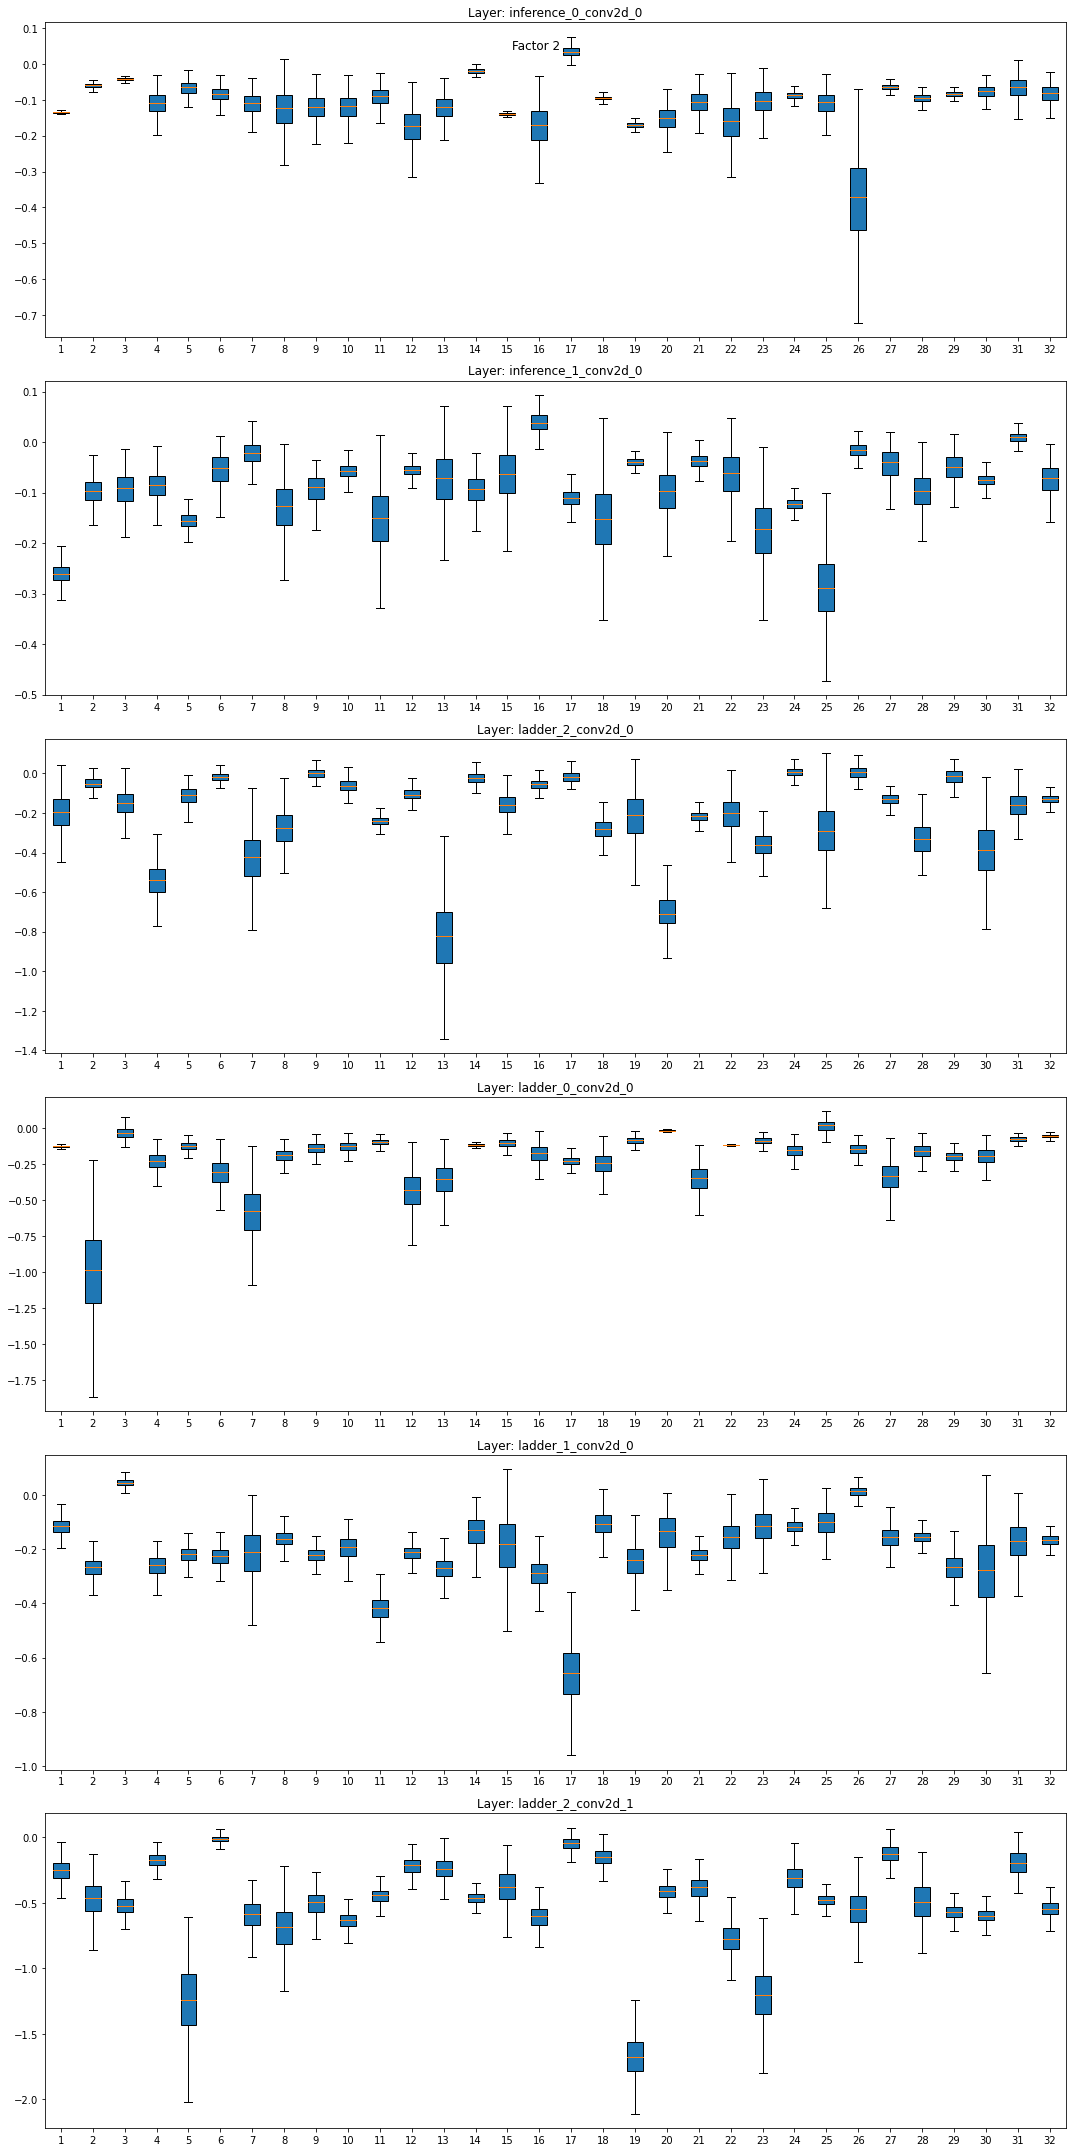

Factor 3
inference_0_conv2d_0 - top activies: [4, 16, 17, 18, 15]
inference_1_conv2d_0 - top activies: [0, 16, 21, 1, 2]
ladder_2_conv2d_0 - top activies: [19, 16, 7, 1, 4]
ladder_0_conv2d_0 - top activies: [16, 0, 1, 13, 21]
ladder_1_conv2d_0 - top activies: [17, 18, 11, 12, 15]
ladder_2_conv2d_1 - top activies: [19, 0, 7, 14, 4]


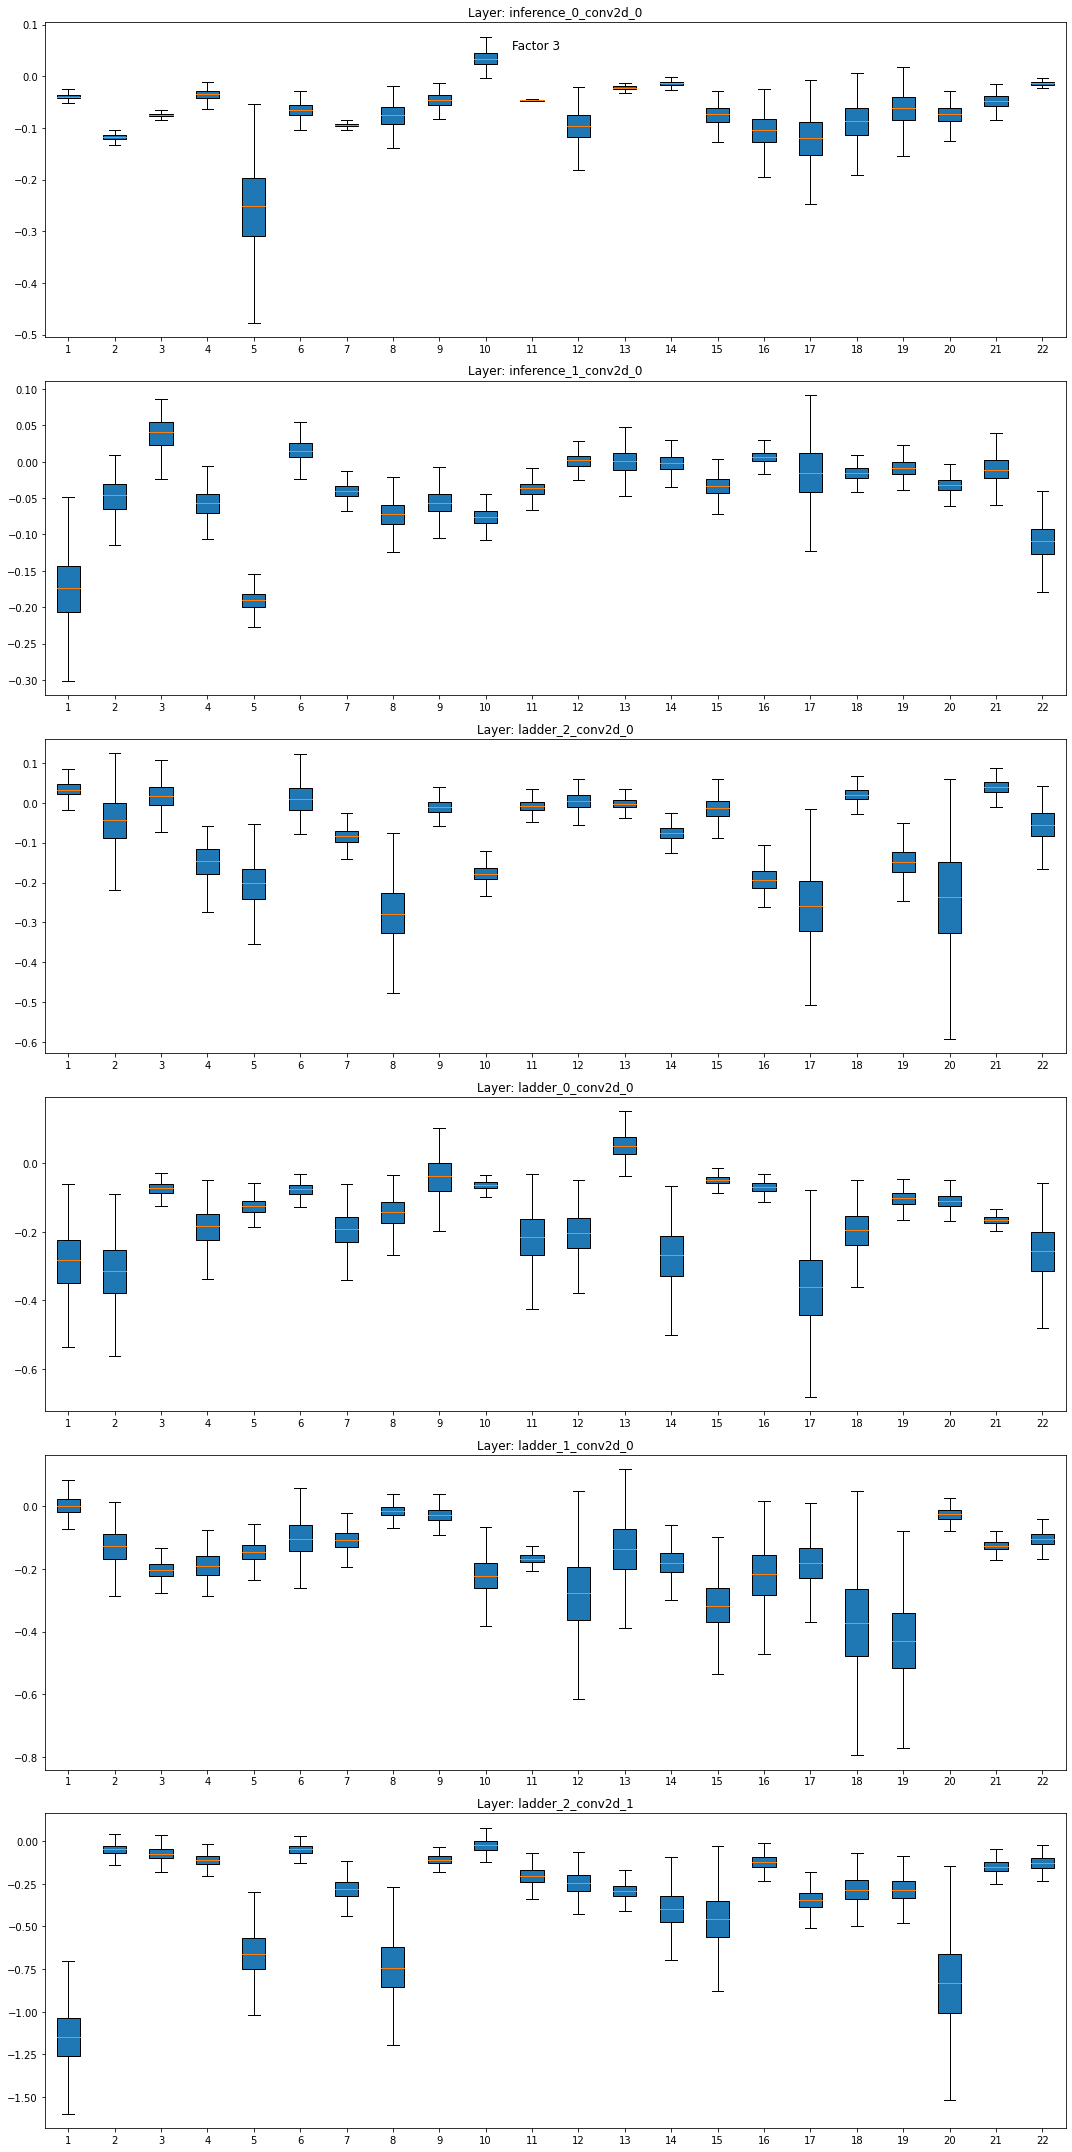

In [10]:
all_keys = list(new_encoders.keys())+ ["Factor 1", "Factor 2", "Factor 3"]
all_values = list(new_encoders.values()) + [vlae_fm1.encoder, vlae_fm2.encoder, vlae_fm3.encoder]

for name, encoder in zip(all_keys, all_values):
    
    print(name)

    conv_layers = [l for l in encoder.layers if isinstance(l, FewActiveLayer if 'Inactive Maps' in name else Conv2D)]
    multi_output_model = Model(encoder.inputs, [l.output for l in conv_layers])
    preds = multi_output_model.predict(np.expand_dims(x_val[:9984] / 255.0, -1))
    fig, axs = plt.subplots(ncols = 1, nrows = len(conv_layers), figsize = (15,5*len(conv_layers)))
    fig.suptitle(name)
    for i, layer in enumerate(conv_layers):
        activies = np.mean(preds[i], axis=(1,2))

        num_fms = activies.shape[-1]
        top_activity_idxs = top_argmax(np.std(activies, axis=0), num_fms//4)
        print(f'{layer.name} - top activies: {top_activity_idxs}')
        ax = axs[i]

        ax.set_title(f"Layer: {layer.name}")
        ax.boxplot(activies,showfliers=False, patch_artist=True)
    fig.tight_layout()
    plt.show(fig)
    print('====================================')

In [12]:
def reconstruction_loss(y_true, y_pred):
    return 10000*np.mean(np.square(y_true - y_pred))

In [13]:
import scipy
from sklearn.utils import shuffle
x_val = shuffle(x_val)

num_splits = 24
splits = [x_val[i*(10000//num_splits):(i+1)*(10000//num_splits)] for i in range(num_splits)]


for name, (sparse_encoder, true_encoder), decoder in zip(list(new_encoders.keys()),zip(list(new_encoders.values()), [vlae_fm1.encoder, vlae_fm2.encoder, vlae_fm3.encoder]) , [vlae_fm1.decoder, vlae_fm2.decoder, vlae_fm3.decoder]):
    print(name)
    sparses = []
    trues = []
    for split in splits:
        split_good_format = np.expand_dims(split/255.0, -1)
        sparses.append(reconstruction_loss(split_good_format,decoder.predict(sparse_encoder.predict(split_good_format))))
        trues.append(reconstruction_loss(split_good_format,decoder.predict(true_encoder.predict(split_good_format))))
    print(scipy.stats.wilcoxon(sparses, trues))
    print(f"Mean sparses: {np.mean(sparses)}")
    print(f"STD Sparses: {np.std(sparses)}")
    print(f"Mean trues: {np.mean(trues)}")
    print(f"STD trues: {np.std(trues)}")

Factor 1 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 949.6478233503309
STD Sparses: 12.621402078316045
Mean trues: 232.8116389679448
STD trues: 8.052615216768196
Factor 2 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 913.3534263491183
STD Sparses: 11.374865878176259
Mean trues: 207.8646742470739
STD trues: 7.341342218963335
Factor 3 - Inactive Maps
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)
Mean sparses: 867.8422890871112
STD Sparses: 11.737754304422385
Mean trues: 200.24595291400024
STD trues: 7.081264075389014


In [ ]:
a = FewActiveLayer([1,2], np.random.standard_normal(100))

top_argmax(np.array([1,2,3,4,5,6,7,8,9,10,11], dtype=np.float32), 5)

In [ ]:
a.inactive_idxs

In [8]:
vlae_fm3.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
inference_0_conv2d_0 (Conv2D)   (None, 14, 14, 22)   572         input_5[0][0]                    
__________________________________________________________________________________________________
inference_0_relu_0 (ReLU)       (None, 14, 14, 22)   0           inference_0_conv2d_0[0][0]       
__________________________________________________________________________________________________
inference_1_conv2d_0 (Conv2D)   (None, 7, 7, 22)     4378        inference_0_relu_0[0][0]         
____________________________________________________________________________________________